<a href="https://colab.research.google.com/github/manish2021iitd/Deep-Learning/blob/main/DLassignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#wandB – Install the W&B library
!pip install wandb
import wandb
from wandb.keras import WandbCallback

#essentials libararies
import numpy as np
from sklearn.metrics import confusion_matrix
import pylab as pl
import random

In [3]:
wandb.login(key='e3c892d4f8c9cd9b9043d31938ad090f0a32cec1')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [12]:
#Q1
wandb.init(project='DLassignment1')
from keras.datasets import fashion_mnist

#Fashion-MNIST dataset
(training_images, training_labels), (testing_images,testing_labels) = fashion_mnist.load_data()


class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

images = [];
labels = [];
for i in range(54000):
  if len(labels) >= 10:
    break;
  if class_names[training_labels[i]] not in labels:
      images.append(training_images[i])
      labels.append(class_names[training_labels[i]])
wandb.log({"examples": [ wandb.Image(img, caption=caption) for img, caption in zip(images,labels)]})

In [5]:
#Q2
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size #number of inputs nodes
        self.hidden_sizes = hidden_sizes #list of neurons in each hidden layer
        self.output_size = output_size #number of output neurons in output layer
        self.weights = [] #list of weight matrices for each layer
        self.biases = []  #list of bias vectors for each hidden layer and output layer

        #innitializing the weights and biases for each layer
        sizes = [input_size] + hidden_sizes + [output_size] #using list concatination to make a list of number of nodes in each layer
        for i in range(len(sizes) - 1):
            self.weights.append(np.random.randn(sizes[i+1], sizes[i]))
            self.biases.append(np.random.randn(sizes[i+1]))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def forward(self, X):
      # Forward pass
      activations = [X]
      for i in range(len(self.weights)):
        z = np.dot(activations[-1], self.weights[i].T) + self.biases[i]
        a = self.sigmoid(z) if i < len(self.weights) - 1 else self.softmax(z)
        activations.append(a)
      return activations

    def predict(self, X):
        #predict output probabilities
        activations = self.forward(X)
        return activations[-1]

#load fashion-mnist dataset
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

#preprocess the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

#define neural network
input_size = X_train.shape[1]  #28x28 images flattened
hidden_sizes = [128, 64]  #size of hidden layers
output_size = 10  # 10 classes in fashion-mnist

#initialize neural network
model = NeuralNetwork(input_size, hidden_sizes, output_size)

#predict probabilities for the test set
probabilities = model.predict(X_test)

#print the output probabilities
print("Output Probabilities:", probabilities)

Output Probabilities: [[1.72713679e-01 5.25393396e-05 3.20151821e-04 ... 4.36616035e-04
  2.23443018e-06 2.04617986e-04]
 [4.48853317e-01 2.53774052e-03 3.29381952e-02 ... 4.63643319e-03
  2.55640324e-04 3.78639669e-04]
 [7.21744560e-01 2.31404443e-03 1.44956911e-01 ... 1.72306672e-05
  5.62395076e-03 1.70804368e-04]
 ...
 [4.79989338e-01 1.18552030e-02 7.27570829e-03 ... 7.50964391e-05
  9.99957799e-04 5.03580507e-07]
 [9.92834041e-01 4.34333665e-03 2.49351452e-05 ... 2.81716898e-06
  5.68792533e-04 1.43278319e-04]
 [1.01112227e-01 6.01226583e-04 3.27763159e-03 ... 4.07127965e-03
  2.86459738e-05 1.87150361e-04]]


In [6]:
#Q3
import numpy as np
from keras.datasets import fashion_mnist

class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, hidden_sizes, output_size, int_method='random'):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes if isinstance(hidden_sizes, list) else [hidden_sizes]
        self.output_size = output_size
        self.weights = []
        self.biases = []

        sizes = [input_size] + self.hidden_sizes + [output_size]

        for i in range(len(sizes) - 1):
            if int_method == "Xavier":
                self.weights.append(np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(1/sizes[i]))
            else:
                self.weights.append(np.random.randn(sizes[i], sizes[i+1]))
            self.biases.append(np.random.randn(1, sizes[i+1]))

        self.adam_v_b = [np.zeros_like(b) for b in self.biases]

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    def MSE(self,y, y_hat, weight_decay,norm):
      loss = np.mean((y-(y_hat.T))**2) + (weight_decay/2)*(norm)
      return loss

    def Cross_entropy(self, y, y_hat,weight_decay,norm):
      #y_hat = np.clip(y_hat.reshape(-1, self.output_size), epsilon, 1 - epsilon)  # clip values to prevent log(0)
      loss = -np.mean(y * np.log(y_hat.T)) + (weight_decay/2)*norm
      return loss

    def frobenius_norm(self,matrix):
      return np.linalg.norm(matrix, ord='fro')


    def evaluate(self, x, y,act_fun,weight_decay,loss_fun):
        predictions = self.forward(x,act_fun)[-1]
        predictions =np.array(predictions)
        norm = 0
        for i in range(len(self.weights)):
          norm += self.frobenius_norm(self.weights[i])**2
        if loss_fun == 'MSE':
          loss = self.MSE(y.reshape(10, -1),predictions,weight_decay,norm)
        else:
          loss = self.Cross_entropy(y.reshape(10, -1),predictions,weight_decay,norm)
        accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y, axis=1))
        return loss, accuracy

    def activation_fun(self, x, act_fun):
        if act_fun == 'sigmoid':
            return self.sigmoid(x)
        elif act_fun == 'tanh':
            return self.tanh(x)
        elif act_fun == 'relu':
            return self.relu(x)

    def der_activation(self, x, act_fun):
        if act_fun == 'sigmoid':
            return self.sigmoid(x) * (1 - self.sigmoid(x))
        elif act_fun == 'tanh':
            return 1. - np.tanh(x) ** 2
        elif act_fun == 'relu':
            return np.where(x <= 0, 0, 1)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X, act_fun):
        activations = [X]
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            if i < len(self.weights) - 1:
                a = self.activation_fun(z, act_fun)
            else:
                a = self.softmax(z)
            activations.append(a)
        return activations

    def backward(self, X, y, act_fun):
        activations = self.forward(X, act_fun)
        delta = activations[-1] - y
        deltas = [delta]
        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(deltas[-1], self.weights[i].T) * self.der_activation(activations[i], act_fun)
            deltas.append(delta)
        deltas.reverse()
        return deltas

    def update(self, X, y, act_fun,optimizer, learning_rate, weight_decay,beta1 = 0.9,beta2=0.999,epsilon=1e-8):
        activations = self.forward(X, act_fun)
        deltas = self.backward(X, y, act_fun)

        if optimizer == 'sgd':
            for i in range(len(self.weights)):
                self.weights[i] -= learning_rate * ((np.dot(activations[i].T, deltas[i]) + weight_decay * self.weights[i]))
                self.biases[i] -= learning_rate * np.mean(deltas[i], axis=0)


        elif optimizer == 'momentum':
            #initialize velocities
            if not hasattr(self, 'velocities'):
                self.velocities = [np.zeros_like(w) for w in self.weights]
            beta1 = 0.9  # momentum parameter
            for i in range(len(self.weights)):
                self.velocities[i] = beta1 * self.velocities[i] + learning_rate * ((np.dot(activations[i].T, deltas[i]) + weight_decay * self.weights[i]))
                self.weights[i] -= self.velocities[i]
                self.biases[i] -= learning_rate * np.mean(deltas[i], axis=0)

        elif optimizer == 'nesterov':
            #initialize velocities
            if not hasattr(self, 'velocities'):
                self.velocities = [np.zeros_like(w) for w in self.weights]
            beta1 = 0.9  # momentum parameter
            for i in range(len(self.weights)):
                lookahead_weights = self.weights[i] - beta1 * self.velocities[i]
                lookahead_biases = self.biases[i] - beta1 * np.mean(self.velocities[i], axis=0)
                self.velocities[i] = beta1 * self.velocities[i] + learning_rate * ((np.dot(activations[i].T, deltas[i]) + weight_decay * lookahead_weights))
                self.weights[i] -= self.velocities[i]
                self.biases[i] -= learning_rate * np.mean(deltas[i], axis=0)


        elif optimizer == 'rmsprop':
          #initialize rmsprop parameters
          if not hasattr(self, 'rmsprop_cache_w'):
            self.rmsprop_cache_w = [np.zeros_like(w) for w in self.weights]
          if not hasattr(self, 'rmsprop_cache_b'):
            self.rmsprop_cache_b = [np.zeros_like(b) for b in self.biases]
          for i in range(len(self.weights)):
            self.rmsprop_cache_w[i] = beta1 * self.rmsprop_cache_w[i] + (1 - beta1) * (np.dot(activations[i].T, deltas[i])**2 )
            self.rmsprop_cache_b[i] = beta1 * self.rmsprop_cache_b[i] + (1 - beta1) * np.mean(deltas[i], axis=0)**2
            #check for very small or zero values in rmsprop_cache_w[i]
            self.rmsprop_cache_w[i][np.abs(self.rmsprop_cache_w[i]) < epsilon] = epsilon
            self.weights[i] -= (learning_rate/ (np.sqrt(self.rmsprop_cache_w[i]) + epsilon))*np.dot(activations[i].T, deltas[i]) + learning_rate * weight_decay * self.weights[i]
            self.biases[i] -= learning_rate * np.mean(deltas[i], axis=0)  / (np.sqrt(self.rmsprop_cache_b[i]) + epsilon)

        elif optimizer == 'adam':
          #initialize adam parameters
          if not hasattr(self, 'adam_m_w'):
            self.adam_m_w = [np.zeros_like(w) for w in self.weights]
          if not hasattr(self, 'adam_m_b'):
            self.adam_m_b = [np.zeros_like(b) for b in self.biases]
          if not hasattr(self, 'adam_v_w'):
            self.adam_v_w = [np.zeros_like(w) for w in self.weights]
          if not hasattr(self, 'adam_m_b'):
            self.adam_v_b = [np.zeros_like(b) for b in self.biases]

          for i in range(len(self.weights)):
            self.adam_m_w[i] = beta1 * self.adam_m_w[i] + (1 - beta1) * np.dot(activations[i].T, deltas[i])
            self.adam_m_b[i] = beta1 * self.adam_m_b[i] + (1 - beta1) * np.mean(deltas[i], axis=0)
            self.adam_v_w[i] = beta2 * self.adam_v_w[i] + (1 - beta2) * (np.dot(activations[i].T, deltas[i]))**2
            self.adam_v_b[i] = beta2 * self.adam_v_b[i] + (1 - beta2) * np.mean(deltas[i], axis=0)**2
            m_w_hat = self.adam_m_w[i] / (1 - beta1**(i+1))
            m_b_hat = self.adam_m_b[i] / (1 - beta1**(i+1))
            v_w_hat = self.adam_v_w[i] / (1 - beta2**(i+1))
            v_b_hat = self.adam_v_b[i] / (1 - beta2**(i+1))
            self.weights[i] -= learning_rate * m_w_hat / (np.sqrt(v_w_hat) + epsilon) + learning_rate * weight_decay * self.weights[i]
            self.biases[i] -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

        elif optimizer == 'nadam':

          #initialize adam parameters
          if not hasattr(self, 'adam_m_w'):
            self.adam_m_w = [np.zeros_like(w) for w in self.weights]
          if not hasattr(self, 'adam_m_b'):
            self.adam_m_b = [np.zeros_like(b) for b in self.biases]
          if not hasattr(self, 'adam_v_w'):
            self.adam_v_w = [np.zeros_like(w) for w in self.weights]
          if not hasattr(self, 'adam_m_b'):
            self.adam_v_b = [np.zeros_like(b) for b in self.biases]
          for i in range(len(self.weights)):
            self.adam_m_w[i] = beta1 * self.adam_m_w[i] + (1 - beta1) * np.dot(activations[i].T, deltas[i])
            self.adam_m_b[i] = beta1 * self.adam_m_b[i] + (1 - beta1) * np.mean(deltas[i], axis=0)
            self.adam_v_w[i] = beta2 * self.adam_v_w[i] + (1 - beta2) * (np.dot(activations[i].T, deltas[i]))**2
            self.adam_v_b[i] = beta2 * self.adam_v_b[i] + (1 - beta2) * np.mean(deltas[i], axis=0)**2
            m_w_hat = self.adam_m_w[i] / (1 - beta1**(i+1))
            m_b_hat = self.adam_m_b[i] / (1 - beta1**(i+1))
            v_w_hat = self.adam_v_w[i] / (1 - beta2**(i+1))
            v_b_hat = self.adam_v_b[i] / (1 - beta2**(i+1))
            m_w_bar = beta1*m_w_hat + (1 - beta1)*np.dot(activations[i].T, deltas[i])
            m_b_bar = beta1*m_b_hat + (1 - beta1)*np.mean(deltas[i], axis=0)
            self.weights[i] -= learning_rate * m_w_bar / (np.sqrt(v_w_hat) + epsilon) + learning_rate * weight_decay * self.weights[i]
            self.biases[i] -= learning_rate * m_b_bar / (np.sqrt(v_b_hat) + epsilon)



    def train(self, X_train, y_train, X_test, y_test_one_hot,act_fun,optimizer,loss_fun, epochs, batch_size, learning_rate, weight_decay):
        for epoch in range(epochs):
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                self.update(X_batch, y_batch, act_fun,optimizer, learning_rate, weight_decay,beta1 = 0.9)


            train_loss, train_accuracy = self.evaluate(X_train, y_train,act_fun, weight_decay,loss_fun)
            wandb.log({"train_accuracy": train_accuracy*100})
            wandb.log({"train_loss": train_loss})
            val_loss, val_accuracy = self.evaluate(X_test, y_test_one_hot,act_fun, weight_decay,loss_fun)
            wandb.log({"val_accuracy": val_accuracy*100})
            wandb.log({"val_loss": val_loss})

        #return train_loss,train_accuracy

    def test(self, X_test, act_fun):
        return self.forward(X_test, act_fun)[-1]

'''
def compute_accuracy(predictions, true_labels):
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(true_labels, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy
'''

#fashion-mnist dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

#preprocessing the data
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

#convert labels to one-hot encoding
num_classes = 10
y_train_one_hot = np.eye(num_classes)[y_train]
y_test_one_hot = np.eye(num_classes)[y_test]

#define neural network
input_size = X_train.shape[1]
hidden_layers = 3
hidden_sizes = [128,64,32]
output_size = num_classes

#initialize neural network
#model = NeuralNetwork(input_size, hidden_layers, hidden_sizes, output_size, int_method='random')

#train the model
act_fun = 'tanh'  #change activation function here
epochs = 2
learning_rate = 0.001
weight_decay = 0.0005  #change weight decay here
batch_size = 16  #choose batch sizes here
optimizer = 'nadam'

#train_loss,train_accuracy=model.train(X_train, y_train_one_hot, act_fun,optimizer, epochs, batch_size, learning_rate, weight_decay)
#print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

#test the model
#predictions = model.test(X_test, act_fun)
#accuracy = NeuralNetwork.evaluate(X_test,predictions, y_test_one_hot)
#print("Accuracy on test set with batch size :", accuracy * 100, "%")

#evaluate on test data
#test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot,act_fun,weight_decay)
#print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

#References:
#1.https://cs229.stanford.edu/main_notes.pdf
#2.http://www.cse.iitm.ac.in/~miteshk/CS6910.html
#3.https://visualstudiomagazine.com/Articles/2017/06/01/Back-Propagation.aspx?Page=2
#4.https://medium.com/@ipylypenko/exploring-neural-networks-with-fashion-mnist-b0a8214b7b7b
#5.https://www.youtube.com/watch?v=Wo5dMEP_BbI&list=PLQVvvaa0QuDcjD5BAw2DxE6OF2tius3V3
#7.https://www.youtube.com/watch?v=LQvRhQwDOm0
#8.https://towardsdatascience.com/implementing-different-activation-functions-and-weight-initialization-methods-using-python-c78643b9f20f
#9.https://medium.com/konvergen/modifying-adam-to-use-nesterov-accelerated-gradients-nesterov-accelerated-adaptive-moment-67154177e1fd

In [ ]:
#Q4,5,6
def main():
    with wandb.init() as run:
        config = wandb.config


        hidden_sizes = [config.hidden_sizes] if isinstance(config.hidden_sizes, int) else config.hidden_sizes

        model = NeuralNetwork(input_size, config.hidden_layers, config.hidden_sizes, output_size, config.int_method)


        model.train(X_train, y_train_one_hot, X_test, y_test_one_hot,config.activation,config.optimizer,config.loss_fun, config.epochs, config.batch_size, config.learning_rate, config.weight_decay)


        model.evaluate(X_test, y_test_one_hot,config.activation,config.weight_decay,config.loss_fun)



#define the sweep configuration
sweep_config = {
    'method': 'random',
    'name': 'sweep_cross_entropy',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values':[3, 4, 5]},
        'hidden_sizes': {'values': [32, 64, 128]},
        'activation': {'values': ['sigmoid', 'relu', 'tanh']},
        'loss_fun': {'values': ['cross_entropy']},
        'weight_decay': {'values': [0,0.0005,0.5]},
        'learning_rate': {'values': [0.0001, 0.00001]},
        'optimizer': {'values': ['sgd','momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'int_method':{'values':['radnom','xavier']}
    }
}

#the sweep
sweep_id = wandb.sweep(sweep=sweep_config, project='DLassignment1')

#run the sweep agent
wandb.agent(sweep_id, function=main,count=150)

Test Accuracy: 83.95%


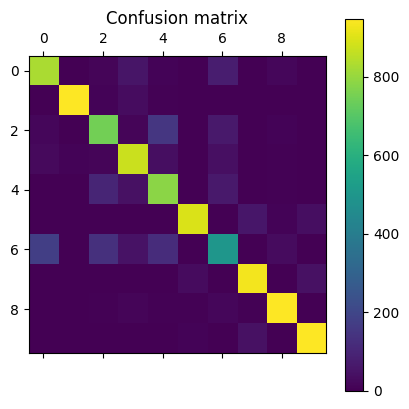

train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
train_accuracy,85.38167
train_loss,637.18387
val_accuracy,83.95
val_loss,637.17833


In [11]:
#Q7 confusion matrix for best hyperparameters for validation accuracy of 83.91%
import numpy as np
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

# Load fashion-mnist dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# Convert labels to one-hot encoding
num_classes = 10
y_train_one_hot = np.eye(num_classes)[y_train]
y_test_one_hot = np.eye(num_classes)[y_test]

# Best hyperparameters
best_epochs = 10
best_hidden_layers = 4
best_hidden_size = 128
best_weight_decay = 0.5
best_learning_rate = 0.0001
best_batch_size = 16
best_act_fun = 'tanh'
best_loss_fun = 'cross_entropy'
best_weight_init = 'random'
best_optimizer = 'rmsprop'

# Define and train the model with best hyperparameters
model = NeuralNetwork(input_size=X_train.shape[1],
                      hidden_layers=best_hidden_layers,
                      hidden_sizes=best_hidden_size,
                      output_size=num_classes,
                      int_method=best_weight_init)

# Initialize W&B run
wandb.init(project='DLassignment1', config={
    'epochs': best_epochs,
    'hidden_layers': best_hidden_layers,
    'hidden_size': best_hidden_size,
    'weight_decay': best_weight_decay,
    'learning_rate': best_learning_rate,
    'batch_size': best_batch_size,
    'activation_function': best_act_fun,
    'loss_function': best_loss_fun,
    'weight_initialization': best_weight_init,
    'optimizer': best_optimizer
})

# Train the model
model.train(X_train, y_train_one_hot, X_test, y_test_one_hot,
            best_act_fun, best_optimizer, best_loss_fun,
            best_epochs, best_batch_size, best_learning_rate,
            best_weight_decay)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot, best_act_fun, best_weight_decay, best_loss_fun)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Generate predictions on the test set
predictions = model.test(X_test, best_act_fun)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

img  = pl.matshow(conf_matrix)
pl.title('Confusion matrix')
pl.colorbar()
pl.show()

wandb.log({"confusion matrix": [ wandb.Image(img, caption='confusion matrix') ]})

wandb.finish()

In [ ]:
#Q8 In all the models above we used cross entropy loss. Now to compare the cross entropy loss with the squared error loss.
def main():
    with wandb.init() as run:
        config = wandb.config


        hidden_sizes = [config.hidden_sizes] if isinstance(config.hidden_sizes, int) else config.hidden_sizes

        model = NeuralNetwork(input_size, config.hidden_layers, config.hidden_sizes, output_size, config.int_method)


        model.train(X_train, y_train_one_hot, X_test, y_test_one_hot,config.activation,config.optimizer,config.loss_fun, config.epochs, config.batch_size, config.learning_rate, config.weight_decay)


        model.evaluate(X_test, y_test_one_hot,config.activation,config.weight_decay,config.loss_fun)



#define the sweep configuration
sweep_config = {
    'method': 'random',
    'name': 'sweep_MSE',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values':[3, 4, 5]},
        'hidden_sizes': {'values': [32, 64, 128]},
        'activation': {'values': ['sigmoid', 'relu', 'tanh']},
        'loss_fun': {'values': ['MSE']},
        'weight_decay': {'values': [0,0.0005,0.5]},
        'learning_rate': {'values': [0.0001, 0.00001]},
        'optimizer': {'values': ['sgd','momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'int_method':{'values':['radnom','xavier']}
    }
}

#the sweep
sweep_id = wandb.sweep(sweep=sweep_config, project='DLassignment1')

# Run the sweep agent
wandb.agent(sweep_id, function=main,count=150)